In [1]:

#Import modules
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,  RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, validation_curve


## Data generation & import

We first generate features and target variables for prediction by running the data generation script.
We use aggregations of transactions for the latest 3000 days (full history excluding the latest 60 days), and the latest 60 days prior to the loan date. These time horizons can be passed to the script as arguments and adjusted as you like.

In [42]:
!ipython credit_risk_datagen.py 3000 60

#open the pickled dataset generated by the script
with open('loan_data', 'rb') as file:
    loans = pickle.load(file, encoding="latin1")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\shellapp.py:340: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  raise_exceptions=True)
credit_risk_datagen.py:181: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]


In [46]:
#Missing observations
loans[loans.isna().sum(axis=1).astype(bool)]

,amount,duration,payments,A4,A5,A6,A7,A8,A9,A10,...,c_deposit_sum_short,c_withdr_sum_short,sanc_max_short,rate_max_short,transactions_sum_short,net_cdeposit_sum_short,net_bdeposit_sum_short,net_bdeposit_max_short,age_mean_short,neg_bal_short
loan_id,,,,,,,,,,,,,,,,,,,,,
5063.0,357840.0,48.0,7455.0,387570.0,0.0,0.0,0.0,1.0,1.0,100.0,...,1,0,0,0.000000,1,9500.0,0.0,0.0,12.000000,0
5314.0,96396.0,12.0,8033.0,94812.0,15.0,13.0,8.0,2.0,10.0,81.8,...,2,0,0,0.000000,2,9100.0,0.0,0.0,30.000000,0
5316.0,165960.0,36.0,4610.0,112709.0,48.0,20.0,7.0,3.0,10.0,73.5,...,2,6,0,0.005412,15,-34137.0,-6838.0,0.0,26.733333,0
5325.0,105804.0,36.0,2939.0,107870.0,84.0,29.0,6.0,1.0,6.0,58.0,...,0,5,0,0.005218,11,-35600.0,44080.0,26448.0,31.363636,0
6111.0,174744.0,24.0,7281.0,122603.0,25.0,21.0,6.0,2.0,8.0,80.0,...,4,2,0,0.008420,10,57566.0,0.0,0.0,29.500000,0
6687.0,87840.0,24.0,3660.0,53921.0,61.0,22.0,1.0,1.0,2.0,41.3,...,0,4,0,0.004120,14,-87200.0,43918.0,21959.0,26.000000,0
6687.0,87840.0,24.0,3660.0,53921.0,61.0,22.0,1.0,1.0,2.0,41.3,...,0,4,0,0.004120,14,-87200.0,43918.0,21959.0,26.000000,0
6863.0,127080.0,60.0,2118.0,77917.0,85.0,19.0,6.0,1.0,5.0,53.5,...,0,4,0,0.004046,13,-33800.0,31304.0,19065.0,30.615385,0
7240.0,274740.0,60.0,4579.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0,4,0,0.004960,11,-84800.0,65490.0,42244.0,34.090909,0


In [31]:
X = loans.drop(['target', 'applicants', 'rate_max'], axis=1)
X2 = loans[~loans.isna().sum(axis=1).astype(bool)]
y2 = X2.target
X2 = X2.drop('target', axis=1)
y = loans.target
kfold = StratifiedKFold(n_splits=10)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\shellapp.py:340: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  raise_exceptions=True)
credit_risk_datagen.py:181: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]


amount                    0
duration                  0
payments                  0
A4                        0
A5                        0
A6                        0
A7                        0
A8                        0
A9                        0
A10                       0
A11                       0
A12                       0
A13                       0
A14                       0
issued                    0
target                    0
gender                    0
appl_age                  0
accnt_age                 0
frequency_trans           0
frequency_weekly          0
multi                     0
rate                      0
applicants                9
balance_min               0
balance_mean              0
balance_max               0
c_deposit_sum             0
c_withdr_sum              0
sanc_max                  0
rate_max                  1
transactions_sum          0
net_cdeposit_sum          0
net_bdeposit_sum          0
net_bdeposit_max          0
age_mean            

number of element in train sample =  [222 309 396 482 569 656 743]


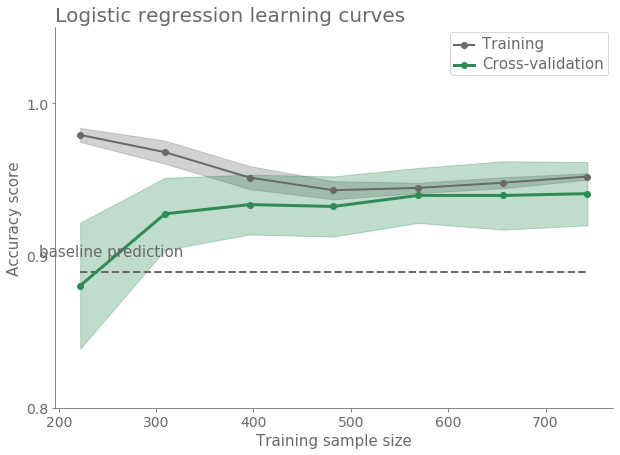

In [40]:
logc = LogisticRegression(penalty='l1', solver='liblinear')
g = plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7),color2="dimgrey",color1="seagreen",plotmedian=False,
                          includebasetext=True )

number of element in train sample =  [220 305 391 477 562 648 734]


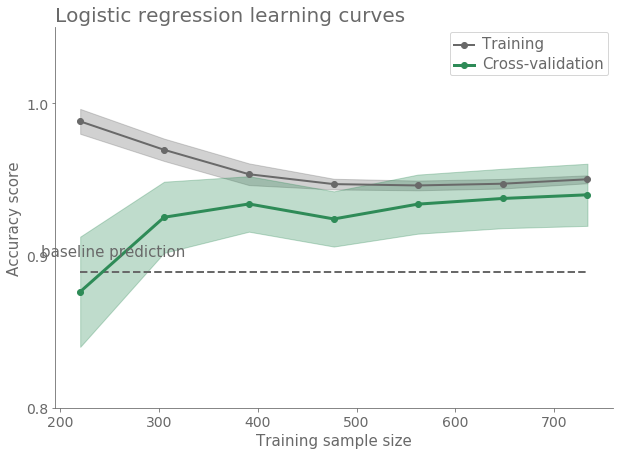

In [41]:
logc = LogisticRegression(penalty='l1', solver='liblinear')
g = plot_learning_curve(logc,"Logistic regression learning curves",X2, y2,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7),color2="dimgrey",color1="seagreen",plotmedian=False,
                          includebasetext=True )

number of element in train sample =  [ 73 238 403 568 734]


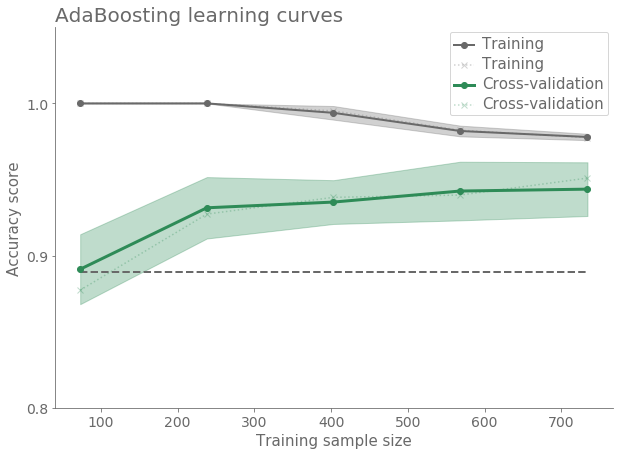

In [12]:
adc = AdaBoostClassifier(**{'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'})
g = plot_learning_curve(adc,"AdaBoosting learning curves",X2,y2,
                           cv=kfold,color2="dimgrey",color1="seagreen")

number of element in train sample =  [220 348 477 605 734]


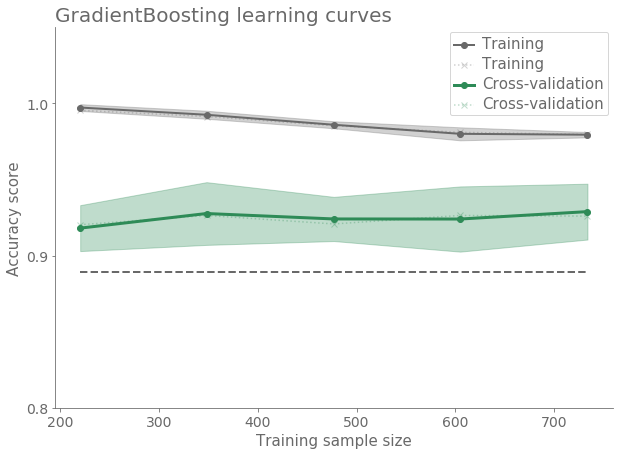

In [13]:
gbc = GradientBoostingClassifier(**{'loss': 'deviance', 'learning_rate': 0.02, 'min_samples_leaf': 20,
                            'n_estimators': 200, 'max_features': 7, 'max_depth': 5})
g = plot_learning_curve(gbc,"GradientBoosting learning curves",X2,y2,cv=kfold,
                           color2="dimgrey",color1="seagreen",
                        train_sizes=np.linspace(.3, 1.0, 5))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),color1 = "g",color2 = "r",
                        plotmedian=True, includebasetext=False, baselinepos=[180,0.9]):
    """
    Generate a simple plot of the test and training learning curve.
    The function is straight up copied from dchornillos repository found here:
    http://github.com/dchornillos/explore_financialdata
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    This is purely to compare preliminary results between his analysis and mine.
    
    """
    fig,ax = plt.subplots(1,1,figsize=(10,7))
    plt.title(title, color="dimgray", loc="left", size=20)
    plt.xlabel("Training sample size", color="dimgrey",size=15)
    plt.ylabel("Accuracy score", color="dimgrey",size=15)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    print ("number of element in train sample = ", train_sizes)

    
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_median = np.median(train_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    if plotmedian:
        test_scores_median = np.median(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()
    plt.plot(train_sizes[:], np.zeros(len(train_sizes))+0.889, ls="--", color = "dimgrey", lw=2)
    if includebasetext:
        plt.text(baselinepos[0], baselinepos[1], "baseline prediction",color="dimgrey",size=15)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color=color2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.3, color=color1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color=color2, lw=2,
             label="Training")
    if plotmedian:
        plt.plot(train_sizes, train_scores_median, 'x:', color=color2,alpha=0.3,
             label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color=color1,
             label="Cross-validation", lw=3)
    if plotmedian:
        plt.plot(train_sizes, test_scores_median, 'x:', color=color1, alpha=0.3,
             label="Cross-validation")
    plt.ylim([0.8,1.05])

    legend=plt.legend(loc="best")
    plt.setp(legend.get_texts(), color='dimgray', size=15)

    ax.spines['bottom'].set_color('dimgray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('dimgray')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray', size=3)
    ax.get_yaxis().set_ticks([0.8,0.9,1.0])

    ax.tick_params(labelsize=14)

    return plt